In [17]:
import networkx as nx
import pandas as pd
from networkx.algorithms import bipartite
from collections import defaultdict

# --- Step 1: Load data ---
reviews_df = pd.read_csv("/Users/jaeeponde/dsm_project/st_louis/cleaned/st_louis_reviews.csv")  # has 'user_id', 'business_id'

# --- Step 2: Build bipartite graph ---
B = nx.Graph()
users = reviews_df['user_id'].unique()
businesses = reviews_df['business_id'].unique()

# Add nodes with type attribute
B.add_nodes_from(users, bipartite='user')
B.add_nodes_from(businesses, bipartite='business')

# Add edges (user to business)
for _, row in reviews_df.iterrows():
    B.add_edge(row['user_id'], row['business_id'])

# --- Step 3: Project to business–business graph ---
# Based on shared users (co-reviews)
business_graph = bipartite.weighted_projected_graph(B, businesses)

# --- Step 4: Recommend similar businesses to each user ---
def recommend_businesses(user, top_n=5):
    # Get businesses the user has already reviewed
    reviewed = set(B.neighbors(user))

    # Score candidates by similarity to reviewed businesses
    scores = defaultdict(float)
    for b in reviewed:
        for neighbor, weight in business_graph[b].items():
            if neighbor not in reviewed:
                scores[neighbor] += weight.get('weight', 1.0)
  # or normalize later

    # Sort and return top N
    recommended = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:top_n]
    return recommended

# --- Example ---
user_to_recommend = reviews_df['user_id'].iloc[0]
recommendations = recommend_businesses(user_to_recommend)
print(f"Recommended businesses for user {user_to_recommend}:")
for biz, score in recommendations:
    print(f"  {biz} (similarity: {score:.2f})")


Recommended businesses for user bm51roWAnief-ga9jMZxKw:
  3XirYkP9PJvVXIEDPNNXLA (similarity: 1.00)
  oiD4N-h7GotnsiXEa4Er5g (similarity: 1.00)
  3VvZpyRMg5p3nH2-iK3-Vg (similarity: 1.00)
  LlYENa9mr9V0vILUO4xGlQ (similarity: 1.00)
  n_UrYjNafyzDCRcwiugnJA (similarity: 1.00)


In [20]:
import random

# Step 1: Create a train-test split
edges = list(B.edges())
random.shuffle(edges)

# Let's remove 10% of the edges for testing
test_edges = edges[:int(len(edges) * 0.1)]  # 10% of edges for testing
train_edges = edges[int(len(edges) * 0.1):]  # Remaining 90% for training

# Create the graph with only the train edges
B_train = B.copy()
B_train.remove_edges_from(test_edges)

# Now B_train contains the training data, and test_edges are the actual edges we want to predict


In [21]:
# Step 2: Predict missing links
def recommend_businesses(user, top_n=5):
    reviewed = set(B_train.neighbors(user))  # Businesses already reviewed
    scores = defaultdict(float)
    
    for b in reviewed:
        for neighbor, weight in business_graph[b].items():
            if neighbor not in reviewed:  # Only recommend businesses not already reviewed
                scores[neighbor] += weight.get('weight', 1.0)
    
    recommended = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:top_n]
    return recommended

# Step 3: Make recommendations for each user in the test set
test_recommendations = []
for user, _ in test_edges:
    recommendations = recommend_businesses(user)
    test_recommendations.append((user, recommendations))

# Output a few sample recommendations for inspection
for user, recs in test_recommendations[:5]:
    print(f"User {user} recommendations:")
    for biz, score in recs:
        print(f"  {biz} (similarity: {score:.2f})")


User q0Ro4oBwIoOZIqBQNE0ADg recommendations:
User r_o4XTYxeRzL_DTbif45TA recommendations:
User KCD6daAp293FoOUoTjT_YA recommendations:
  2BMk_drsikKWslJCXmQtjQ (similarity: 2.00)
  AtQLrRpQan7UtJcIAo9hsA (similarity: 2.00)
  JKnKGY2U5med1efsERZQ5g (similarity: 2.00)
  dtU_DsHVOCi-2-mWe7gabw (similarity: 2.00)
  Vm2vdXFSZ7U746n4ySCVtQ (similarity: 2.00)
User VVZDOulqd2hnJpJVD3M1lw recommendations:
User V-RPKFzbUAh2-vzcnGY_Aw recommendations:
  2PeuTPjcC5jEyrMt9o-w7w (similarity: 1.00)
  _xWm_EgCq4dGTjo_DmEVWw (similarity: 1.00)
  56M2bwaaSzcmzr2dyEfYQw (similarity: 1.00)
  OZ3ncfIHMQgSoxVCXKRxbQ (similarity: 1.00)
  SXWlFsPfV0hO3Go2qsExnA (similarity: 1.00)


In [22]:
# Step 4: Evaluate predictions
def evaluate_predictions(test_edges, recommendations):
    hit_count = 0
    total_recommendations = 0
    
    for user, recs in recommendations:
        # Get the businesses recommended for this user
        recommended_businesses = set([biz for biz, _ in recs])
        
        # Check if any of the recommended businesses are in the test edges for this user
        actual_businesses = set([biz for _, biz in test_edges if _ == user])
        
        # Count how many of the recommended businesses are in the actual businesses
        hit_count += len(recommended_businesses.intersection(actual_businesses))
        total_recommendations += len(recommended_businesses)
    
    # Hit Rate: Percentage of recommended businesses that were actual links
    hit_rate = hit_count / total_recommendations if total_recommendations > 0 else 0
    return hit_rate

hit_rate = evaluate_predictions(test_edges, test_recommendations)
print(f"Hit Rate@5: {hit_rate:.4f}")


Hit Rate@5: 0.1966


In [32]:
import random
import networkx as nx
import pandas as pd
from networkx.algorithms import bipartite
from collections import defaultdict
from sklearn.preprocessing import MinMaxScaler
# --- Step 1: Load data ---
reviews_df = pd.read_csv("/Users/jaeeponde/dsm_project/st_louis/cleaned/st_louis_reviews.csv")  # has 'user_id', 'business_id', 'stars'

# --- Step 2: Build bipartite graph ---

# --- Step 2: Normalize star ratings ---
scaler = MinMaxScaler(feature_range=(0, 1))  # Normalize star ratings to range [0, 1]
reviews_df['normalized_stars'] = scaler.fit_transform(reviews_df[['stars']])

B = nx.Graph()
users = reviews_df['user_id'].unique()
businesses = reviews_df['business_id'].unique()

# Add nodes with type attribute
B.add_nodes_from(users, bipartite='user')
B.add_nodes_from(businesses, bipartite='business')

# Add edges (user to business) with 'stars' as weight
for _, row in reviews_df.iterrows():
    B.add_edge(row['user_id'], row['business_id'], weight=row['stars'])

# --- Step 3: Train-test split for evaluation ---
edges = list(B.edges())
random.shuffle(edges)

# Let's remove 10% of the edges for testing
test_edges = edges[:int(len(edges) * 0.1)]  # 10% of edges for testing
train_edges = edges[int(len(edges) * 0.1):]  # Remaining 90% for training

# Create the graph with only the train edges
B_train = B.copy()
B_train.remove_edges_from(test_edges)

# --- Step 4: Project to business–business graph based on shared users ---
business_graph_train = bipartite.weighted_projected_graph(B_train, businesses)

# --- Step 5: Recommend similar businesses to each user (integrating star ratings) ---
def recommend_businesses(user, top_n=5):
    # Get businesses the user has already reviewed
    reviewed = set(B.neighbors(user))

    # Score candidates by similarity to reviewed businesses
    scores = defaultdict(float)
    for b in reviewed:
        for neighbor, data in business_graph_train[b].items():
            if neighbor not in reviewed:
                # Use the 'weight' attribute to scale the similarity
                similarity = data.get('weight', 1.0)
                # Integrate the user's star rating for business b
                user_rating = reviews_df.loc[(reviews_df['user_id'] == user) & (reviews_df['business_id'] == b), 'stars'].values[0]
                scores[neighbor] += similarity * user_rating  # Adjust score by user's rating of business b

    # Sort and return top N
    recommended = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:top_n]
    return recommended

# --- Step 6: Evaluate model --- 
def evaluate_model(test_edges, top_n=5):
    hits = 0
    total = 0

    for user, business in test_edges:
        # Get top N recommendations for the user
        recommendations = recommend_businesses(user, top_n)
        
        # Check if the actual business is in the top N
        recommended_businesses = [business for business, _ in recommendations]
        if business in recommended_businesses:
            hits += 1
        total += 1

    # Calculate Hit Rate@5
    hit_rate = hits / total
    print(f"Hit Rate@{top_n}: {hit_rate:.4f}")

# --- Example usage ---
# Evaluate the model on the test set
evaluate_model(test_edges, top_n=5)



Hit Rate@5: 0.0000


In [33]:
import pandas as pd
import ast
import json

# Load your CSV
df = pd.read_csv("/Users/jaeeponde/dsm_project/st_louis/cleaned/st_louis_restaurants.csv")

# Parse the 'attributes' column which is a string of dictionaries
def safe_parse(val):
    try:
        return ast.literal_eval(val)
    except:
        return {}

df['parsed_attributes'] = df['attributes'].apply(safe_parse)

# Expand nested dictionaries in 'attributes'
attributes_df = df['parsed_attributes'].apply(pd.Series)

# Handle nested dictionaries in columns like 'Ambience', 'BusinessParking', etc.
for col in attributes_df.columns:
    if attributes_df[col].apply(lambda x: isinstance(x, str)).any():
        try:
            attributes_df[col] = attributes_df[col].apply(safe_parse)
        except:
            pass

nested_cols = [col for col in attributes_df.columns if attributes_df[col].apply(lambda x: isinstance(x, dict)).any()]
for col in nested_cols:
    expanded = attributes_df[col].apply(pd.Series)
    expanded.columns = [f"{col}_{subcol}" for subcol in expanded.columns]
    attributes_df = attributes_df.drop(columns=col).join(expanded)


In [39]:
attributes_df = attributes_df.dropna(axis=1, how='all')
attributes_df

,Alcohol_0,BikeParking_0,BusinessAcceptsCreditCards_0,OutdoorSeating_0,RestaurantsTakeOut_0,Caters_0,RestaurantsGoodForGroups_0,Ambience_romantic,Ambience_intimate,Ambience_classy,...,Music_dj,Music_background_music,Music_no_music,Music_jukebox,Music_live,Music_video,Music_karaoke,RestaurantsCounterService_0,ByAppointmentOnly_0,BYOBCorkage_0
0,none,True,True,True,True,False,True,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,True,True,False,False,None,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,True,True,False,True,NaN,True,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,full_bar,True,True,True,True,True,True,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,full_bar,False,True,NaN,True,True,True,False,False,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
538,NaN,True,True,NaN,True,True,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN
539,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
540,full_bar,False,True,False,True,False,True,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
541,full_bar,False,True,True,True,True,True,False,False,True,...,False,False,False,False,False,False,False,NaN,NaN,NaN


In [34]:
# Convert categories to dummy variables (multi-label)
df['categories'] = df['categories'].fillna('').apply(lambda x: [cat.strip() for cat in x.split(',')])
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
categories_df = pd.DataFrame(mlb.fit_transform(df['categories']), columns=mlb.classes_)


In [38]:
categories_df

,Active Life,Afghan,Air Duct Cleaning,Airport Lounges,Airport Shuttles,Airport Terminals,Airports,American (New),American (Traditional),Arabic,...,Venues & Event Spaces,Vietnamese,Waffles,Web Design,Wedding Planning,Whiskey Bars,Wine & Spirits,Wine Bars,Wraps,Yoga
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
538,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
539,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
540,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
541,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [35]:
X = pd.concat([attributes_df, categories_df, df[['review_count']]], axis=1)
y = df['stars']

# Convert boolean and categorical strings to actual numeric values
X = X.replace({'True': 1, 'False': 0, 'None': None, 'none': None, 'u\'none\'': None, 'u\'casual\'': 'casual'})
X = pd.get_dummies(X, dummy_na=True)
X = X.fillna(0)


In [42]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("R2 Score:", r2_score(y_test, y_pred))


RMSE: 0.6306978805369189
R2 Score: 0.6047650428601294


/Users/jaeeponde/anaconda3/envs/kcdha/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


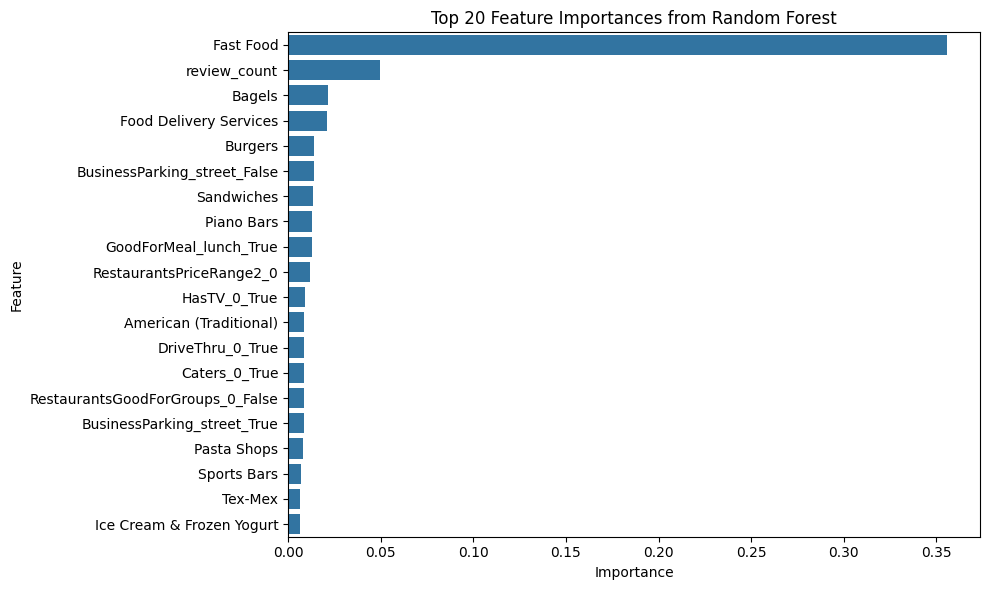

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming rf_model is your trained model and X_train was used to fit it
feature_importances = pd.Series(model.feature_importances_, index=X_train.columns)
feature_importances = feature_importances.sort_values(ascending=False)

# Display top features
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances[:20], y=feature_importances.index[:20])
plt.title("Top 20 Feature Importances from Random Forest")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [47]:
import pandas as pd
import numpy as np

# Step 1: Ideal restaurant features
ideal_features = {
    'Ambience_classy_True': 1,
    'Corkage_False': 1,
    'BYOB_False': 1,
    'BusinessAcceptsBitcoin_False': 1,
    'RestaurantsTableService_True': 1,
    'DogsAllowed_True': 1,
    'WheelchairAccessible_True': 1,
    'BusinessParking_street_True': 1,
    'RestaurantsPriceRange2_2': 1,
    'categories_Vegan': 1,
    'categories_Bars': 1,
    'categories_Nightlife': 1,
    'categories_Mediterranean': 1,
    'categories_Greek': 1,
    'categories_Cafes': 1,
}

# Step 2: Create a DataFrame row with all model features, fill others with 0
input_row = pd.DataFrame([{
    col: ideal_features.get(col, 0) for col in X_train.columns
}])

# Step 3: Predict using the trained random forest model
predicted_star_rating = model.predict(input_row)[0]

print(f"Predicted star rating for ideal restaurant: {predicted_star_rating:.2f}")


Predicted star rating for ideal restaurant: 4.09
